In [1]:
import pandas as pd
import random as rd
from collections import Counter
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def generate_random_solution(df):
    category = df.category.values.tolist()
    np.random.shuffle(category)
    category_copy = category.copy()
    hard_constrait = []
    for cand in category_copy:
        if cand == 'Ht' or cand == 'St':
            hard_constrait.append(cand)
            category.remove(cand)

    empty_space = total - len(hard_constrait)

    soft_constrait = []
    for cand in range(empty_space):
        soft_constrait.append(np.random.choice(category))

    solution = hard_constrait + soft_constrait
    
    return solution, hard_constrait, category

In [3]:
def evaluate_solution(solution, weight):
    frequency = Counter(solution)
    loss = 0
    for category in solution: loss += weight[category] * frequency[category]
    return loss

In [4]:
def levyFlight(empty_space, category):
    """this will allow us jump over long distances 10% of the time and ...
    add all the next seven categories in front as the short distance search"""
    soft_constrait = []
    while len(soft_constrait) < empty_space:
        choice_idx = np.random.choice(empty_space)
        if choice_idx < 175:
            soft_constrait += category[choice_idx:choice_idx+7]
        else: soft_constrait.append(category[choice_idx])
    soft_constrait = soft_constrait[:empty_space+1]
    return soft_constrait

In [5]:
def mutate_solution(hard_constrait, category):
#   mutate the solution by generating new soft constrait solution
    empty_space = total - len(hard_constrait)

    soft_constrait = levyFlight(empty_space, category)
    solution = hard_constrait + soft_constrait    
    return solution

In [6]:
def cuckoo_CA(df, num_itr = 200, num_nests = 4):
    start_time = time.time()
    record = {}
#     create nests and insert one solution in each
    nests = {}
    for nest in range(num_nests):
        solution = generate_random_solution(df)
        new_category = solution[-1].copy()
        cost = evaluate_solution(solution[0], weight)
        solution = list(solution[:-1])
        solution.append(cost)
        nests[nest] = solution
        
    
#     create a cuckoo solution
    cuckoo_solution, hard_sol, _ = nests[0]
    cuckoo_solution = mutate_solution(hard_sol, new_category)
    cost = evaluate_solution(cuckoo_solution, weight) # calculate the fitness function of the cuckoo solution
    record[0] = cost

# compare cuckoo solution with another solution a random nest
    idx_c_nest = np.random.choice(list(nests.keys()))
    if cost > nests[idx_c_nest][-1]:
        nests[idx_c_nest] = (cuckoo_solution, hard_sol, cost)
        print("Iteration 0.... cuckoo solution replaces solution at nest {} with cost {}".format(idx_c_nest+1, cost))
        
    for itr in range(num_itr):
        cuckoo_solution = mutate_solution(hard_sol, new_category)
        cost = evaluate_solution(cuckoo_solution, weight) # calculate the fitness function of the cuckoo solution
        
        idx_c_nest = np.random.choice(list(nests.keys()))
        if cost > nests[idx_c_nest][-1]:
            nests[idx_c_nest] = (cuckoo_solution, hard_sol, cost)
            record[itr] = cost
            print("Iteration {}.... cuckoo solution replaces solution at nest {} with cost {}".format(itr, idx_c_nest+1, cost))
    
#     select the best solution within all nests
    nests = {v[-1]:v[0] for k,v in nests.items()}
    best_cost = max(list(nests.keys()))
    best_solution = nests[best_cost]
    
    end_time = time.time()
    print("\n Time taken - {}seconds".format(end_time-start_time))
    return best_solution, record

In [7]:
def generate_random_solution_HA(CA, HA_stat):
    np.random.shuffle(CA)
    generated = {}
    CA_copy = CA.copy()
    for hall in HA_stat:
        candidates = []
        for count in range(HA_stat[hall]):
            student = np.random.choice(CA_copy)
            candidates.append(student)
            CA_copy.remove(student)
        generated[hall] = candidates
    
    generated = list(generated.values())
    
    matrix_solution = []
    for hall in generated:
        solution = []
        
        frequency = Counter(hall) #count each category in each hall
        for category in order:
            solution.append(frequency[category]) #append count of each category in each hall
        
        matrix_solution.append(solution) # concatenate solutions of all categories in all halls together
    
#     transpose solution to allow rows represent each category and column represent each hall
    matrix_solution = np.array(matrix_solution).transpose()
    return matrix_solution

In [8]:
def evaluate_solution_HA(solution, data):
    solution = {i:j for i,j in zip(data, solution)}
    cost = 0
    for cat in solution: #loop through each category 
        proportion = data[cat] - (max(solution[cat]) - min(solution[cat]))
        N = sum(solution[cat] > 0 ) #number of halls that have some students of i-th category
        cost += proportion * N
    return cost

In [9]:

def levyFlight_HA(empty_space, CA):
    """this will allow us jump over long distances 10% of the time and ...
    add all the next seven categories in front as the short distance search"""
    space = empty_space
    soft_constrait = []
    while len(soft_constrait) < space:
            
        choice_idx = np.random.choice(empty_space)
        picker = np.random.choice(np.linspace(0.1, 0.8, 8))
        
        if picker*empty_space < choice_idx <= ((picker+0.1)*empty_space): #10% probability
            if choice_idx+3 > len(CA) and len(CA) > 3:
                soft_constrait += CA[choice_idx-3:choice_idx]
                del CA[choice_idx-3:choice_idx]
                empty_space -= len(CA[choice_idx-3:choice_idx])
            
            elif len(CA) <= 3:
                soft_constrait += CA[:]
                del CA[:]
                empty_space -= len(CA[:])
                
            else:
                soft_constrait += CA[choice_idx:choice_idx+3]
                del CA[choice_idx:choice_idx+3]
                empty_space -= len(CA[choice_idx:choice_idx+3])
        
        elif choice_idx < len(CA):
            soft_constrait.append(CA[choice_idx-1])
            empty_space -= 1
            CA.remove(CA[choice_idx-1])
            
    CA += soft_constrait[space:]  
    soft_constrait = soft_constrait[:space]

    return soft_constrait, CA

In [10]:
def mutate_solution_HA(CA, HA_stat):
    generated = {}
    CA_copy = CA.copy()
    for hall in HA_stat:
        candidates, CA_copy = levyFlight_HA(HA_stat[hall], CA_copy)
        generated[hall] = candidates        
        
    generated = list(generated.values())
    
    matrix_solution = []
    for hall in generated:
        solution = []
        
        frequency = Counter(hall) #count each category in each hall
        for category in order:
            solution.append(frequency[category]) #append count of each category in each hall
        
        matrix_solution.append(solution) # concatenate solutions of all categories in all halls together
    
#     transpose solution to allow rows represent each category and column represent each hall
    matrix_solution = np.array(matrix_solution).transpose()
    return matrix_solution

In [11]:
def cuckoo_HA(df, num_itr = 200, num_nests = 4):
    start_time = time.time()
    record = {}
# create nests and insert a solution into each of them
    nests = {}
    for nest in range(num_nests):
        solution = generate_random_solution_HA(best_solution_CA, HA_data)
        cost = evaluate_solution_HA(solution, best_solution_CA_dict)
        nests[nest] = (solution, cost)
        
# create a cuckoo solution
    cuckoo_solution = mutate_solution_HA(best_solution_CA, HA_data)
    cost = evaluate_solution_HA(cuckoo_solution, best_solution_CA_dict)
    record[0] = cost
    
# compare cuckoo solution with another solution a random nest
    idx_c_nest = np.random.choice(list(nests.keys()))
    if cost > nests[idx_c_nest][-1]:
        nests[idx_c_nest] = (cuckoo_solution, cost)
        print("Iteration 0.... cuckoo solution replaces solution at nest {} with cost {}".format(idx_c_nest+1, cost))
        
    for itr in range(num_itr):
        cuckoo_solution = mutate_solution_HA(best_solution_CA, HA_data)
        cost = evaluate_solution_HA(cuckoo_solution, best_solution_CA_dict)
        
        idx_c_nest = np.random.choice(list(nests.keys()))
        if cost > nests[idx_c_nest][-1]:
            nests[idx_c_nest] = (cuckoo_solution, cost)
            record[itr] = cost
            print("Iteration {}.... cuckoo solution replaces solution at nest {} with cost {}".format(itr, idx_c_nest+1, cost))
            
#     select the best solution within all nests
    nests = {v[-1]:v[0] for k,v in nests.items()}
    best_cost = max(list(nests.keys()))
    best_solution = nests[best_cost]
    
    end_time = time.time()
    
    print("\n Time taken - {}seconds".format(end_time-start_time))
    print(' Best Fitness value -', best_cost)
    return best_solution, record

## **Implementation - Male applicants**

In [12]:
male_df = pd.read_csv('male_applicants.csv')

In [13]:
male_df

,names,category,weight
0,rqtttt,Ot,0.5
1,zhuztd,Ot,0.5
2,hqxfqg,Ot,0.5
3,sanjtt,Fy,0.5
4,mjbgpk,Ot,0.5
...,...,...,...
7361,bpgonl,Fr,0.5
7362,cvflwj,Fy,0.5
7363,carssw,Ot,0.5
7364,vtofrz,St,1.0


In [14]:
#this represents the amount of student that applied for each category
male_data = {'Fy': 1360, 'Fr':1660, 'Ht':60, 'Sp':290, 'St':260, 'Ot':3736} 

#total amount of students that can be taken by all male hostels
total = 2072 

#total amount of students that belong to the soft constrait group
soft_constr_weight = 1368 + 1660 + 290 + 3736 

#weight the population of the soft constrait group based the amount of people that applied
weight = {'Fy': 1 - (1360/soft_constr_weight), 'Fr': 1-(1660/soft_constr_weight), 'Ht':1, 'Sp':1- (290/soft_constr_weight), 'St':1, 'Ot': 1- (3736/soft_constr_weight)}
print(weight)

{'Fy': 0.8072015877516303, 'Fr': 0.7646725262262546, 'Ht': 1, 'Sp': 0.9588885738588036, 'St': 1, 'Ot': 0.47037142047065494}


In [15]:
#amount of students that can be allocated to each male hostel
HA_data = {'Akindeko': 625, 'Abiola':356, 'Adeniyi':195, 'New Male Hostel':792, 'Bisi Balogun':104}
order = ['Fy','Fr','Ht','Sp','St','Ot']

#### **Generate a random solution - Category Allocation (CA): MALE APPLICANTS**m

In [16]:
solution, _ , _= generate_random_solution(male_df)
frequency = Counter(solution)

show = pd.DataFrame()
for i in frequency: show[i] = [frequency[i]]
show.head()

,St,Ht,Ot,Fy,Fr,Sp
0,260,60,920,328,436,68


#### **Cuckoo optimized solution - Category Allocation (CA) MALE APPLICANTS**

In [25]:
best_solution_CA, graph = cuckoo_CA(male_df)

frequency = Counter(best_solution_CA)

best_solution_CA_dict = {i:j for i,j in frequency.items()}

show = pd.DataFrame()
for i in frequency: show[i] = [frequency[i]]
show.head()

Iteration 0.... cuckoo solution replaces solution at nest 1 with cost 725379.4984406009
Iteration 1.... cuckoo solution replaces solution at nest 4 with cost 733373.1746526825
Iteration 2.... cuckoo solution replaces solution at nest 3 with cost 722770.9050184416
Iteration 3.... cuckoo solution replaces solution at nest 3 with cost 727068.9123901286
Iteration 12.... cuckoo solution replaces solution at nest 2 with cost 730007.776013605
Iteration 19.... cuckoo solution replaces solution at nest 1 with cost 725969.9997164812
Iteration 20.... cuckoo solution replaces solution at nest 1 with cost 733376.4927700494
Iteration 21.... cuckoo solution replaces solution at nest 4 with cost 733727.579529347
Iteration 25.... cuckoo solution replaces solution at nest 2 with cost 732085.3260561286
Iteration 26.... cuckoo solution replaces solution at nest 4 with cost 737010.5154522036
Iteration 30.... cuckoo solution replaces solution at nest 3 with cost 737535.7745959675
Iteration 41.... cuckoo sol

,St,Ht,Fr,Ot,Fy,Sp
0,260,60,354,1038,304,57


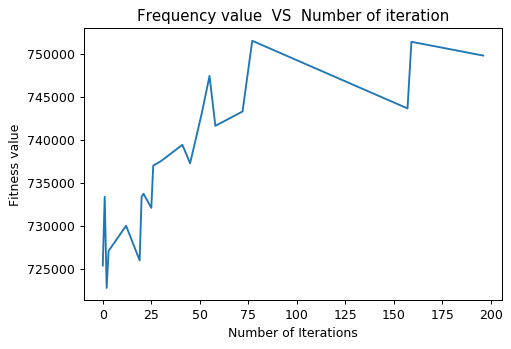

In [26]:
plt.figure(dpi = 90)
plt.title("Frequency value  VS  Number of iteration")
plt.xlabel('Number of Iterations')
plt.ylabel('Fitness value')
plt.plot(list(graph.keys()), list(graph.values()))
plt.show()

#### **Generate a random solution- Hall Allocation (HA) MALE APPLICANTS**

In [27]:
solution_HA = generate_random_solution_HA(best_solution_CA, HA_data)

show = pd.DataFrame(solution_HA,
                    columns = ['Akindeko', 'Abiola', 'Adeniyi', 'New Male Hostel', 'Bisi Balogun'],
                    index = ['Fy','Fr','Ht','Sp','St','Ot'])

show

,Akindeko,Abiola,Adeniyi,New Male Hostel,Bisi Balogun
Fy,85,48,25,125,21
Fr,115,57,38,125,19
Ht,18,14,4,21,3
Sp,11,10,9,22,5
St,59,49,26,104,21
Ot,337,178,93,395,35


#### **Cuckoo optimized solution- Hall Allocation (HA) MALE APPLICANTS**

In [28]:
result, graph = cuckoo_HA(male_df) 
show = pd.DataFrame(result,
                    columns = ['Akindeko', 'Abiola', 'Adeniyi', 'New Male Hostel', 'Bisi Balogun'],
                    index = ['Fy','Fr','Ht','Sp','St','Ot'])

show

Iteration 28.... cuckoo solution replaces solution at nest 4 with cost 6920

 Time taken - 34.89301514625549seconds
 Best Fitness value - 6925


,Akindeko,Abiola,Adeniyi,New Male Hostel,Bisi Balogun
Fy,92,54,24,120,14
Fr,109,63,30,144,8
Ht,23,7,5,23,2
Sp,19,11,3,21,3
St,80,42,27,91,20
Ot,302,179,106,393,57


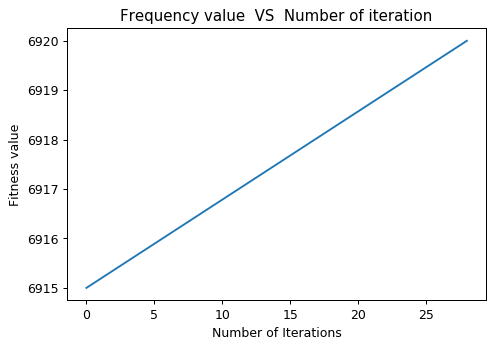

In [29]:
plt.figure(dpi = 90)
plt.title("Frequency value  VS  Number of iteration")
plt.xlabel('Number of Iterations')
plt.ylabel('Fitness value')
plt.plot(list(graph.keys()), list(graph.values()))
plt.show()

## **Implementation - Female applicants**

In [12]:
# Read in data
female_df = pd.read_csv('female_applicants.csv')
female_df.head()

,names,category
0,ymguns,Fy
1,xhvcdk,Fy
2,vdnszo,Ot
3,vbcnxs,Ot
4,wcdduo,Ot


In [13]:
#this represents the amount of student that applied for each category
female_data = {'Fy': 820, 'Fr':958, 'Ht':56, 'Sp':80, 'St':100, 'Ot':1120} 

#total amount of students that can be taken by all male hostels
total = 1593

#total amount of students that belong to the soft constrait group
soft_constr_weight = 820 + 958 + 80 + 1120 

#weight the population of the soft constrait group based the amount of people that applied
weight = {'Fy': 1 - (820/soft_constr_weight), 'Fr': 1-(958/soft_constr_weight), 'Ht':1, 'Sp':1- (80/soft_constr_weight), 'St':1, 'Ot': 1- (1120/soft_constr_weight)}
print(weight)

{'Fy': 0.7246474143720618, 'Fr': 0.6783075889858965, 'Ht': 1, 'Sp': 0.9731363331094695, 'St': 1, 'Ot': 0.6239086635325721}


In [14]:
#amount of students that can be allocated to each male hostel
HA_data = {'New Female Hostel': 792, 'Jadesola':229, 'Jibowu(Main)':332, 'Jibowu Annex 1':80, 'Jibowu Annex 2':80,'Jibowu Annex 3':80}
order = ['Fy','Fr','Ht','Sp','St','Ot']

#### **Generate a random solution - Category Allocation (CA): FEMALE APPLICANTS**

In [15]:
solution, _ , _= generate_random_solution(female_df)
frequency = Counter(solution)

show = pd.DataFrame()
for i in frequency: show[i] = [frequency[i]]
show.head()

,Ht,St,Ot,Fr,Fy,Sp
0,56,100,529,434,439,35


#### **Cuckoo optimized solution - Category Allocation (CA) FEMALE APPLICANTS**

In [16]:
best_solution_CA, graph = cuckoo_CA(female_df)

frequency = Counter(best_solution_CA)

best_solution_CA_dict = {i:j for i,j in frequency.items()}

show = pd.DataFrame()
for i in frequency: show[i] = [frequency[i]]
show.head()

Iteration 0.... cuckoo solution replaces solution at nest 1 with cost 460760.49563465314
Iteration 0.... cuckoo solution replaces solution at nest 1 with cost 461476.3774345163
Iteration 1.... cuckoo solution replaces solution at nest 3 with cost 462092.27871053864
Iteration 2.... cuckoo solution replaces solution at nest 2 with cost 463998.44526528
Iteration 3.... cuckoo solution replaces solution at nest 1 with cost 462562.09939557343
Iteration 4.... cuckoo solution replaces solution at nest 1 with cost 463449.97918065236
Iteration 7.... cuckoo solution replaces solution at nest 4 with cost 461079.2478173291
Iteration 8.... cuckoo solution replaces solution at nest 3 with cost 464028.8844862217
Iteration 10.... cuckoo solution replaces solution at nest 4 with cost 461646.89926124946
Iteration 14.... cuckoo solution replaces solution at nest 4 with cost 465870.71994628
Iteration 15.... cuckoo solution replaces solution at nest 1 with cost 467537.3673606323
Iteration 20.... cuckoo solu

,St,Ht,Ot,Fy,Fr,Sp
0,100,56,566,353,496,23


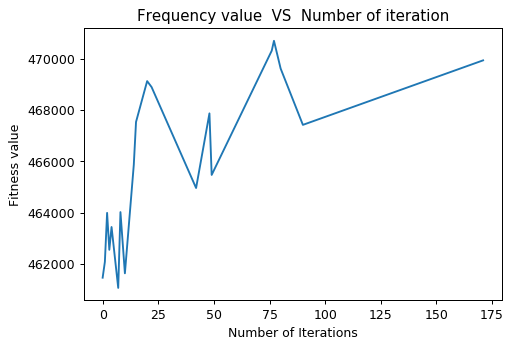

In [18]:
plt.figure(dpi = 90)
plt.title("Frequency value  VS  Number of iteration")
plt.xlabel('Number of Iterations')
plt.ylabel('Fitness value')
plt.plot(list(graph.keys()), list(graph.values()))
plt.show()

#### **Cuckoo optimized solution- Hall Allocation (HA) FEMALE APPLICANTS**

In [21]:
result, graph = cuckoo_HA(200) 
show = pd.DataFrame(result,
                    columns = ['New Female Hostel', 'Jadesola', 'Jibowu(Main)', 'Jibowu Annex 1', 'Jibowu Annex 2','Jibowu Annex 3'],
                    index = ['Fy','Fr','Ht','Sp','St','Ot'])

show

Iteration 0.... cuckoo solution replaces solution at nest 1 with cost 5196
Iteration 0.... cuckoo solution replaces solution at nest 4 with cost 5190
Iteration 5.... cuckoo solution replaces solution at nest 2 with cost 5196
Iteration 6.... cuckoo solution replaces solution at nest 1 with cost 5208
Iteration 10.... cuckoo solution replaces solution at nest 4 with cost 5214
Iteration 11.... cuckoo solution replaces solution at nest 1 with cost 5226
Iteration 17.... cuckoo solution replaces solution at nest 2 with cost 5214
Iteration 26.... cuckoo solution replaces solution at nest 4 with cost 5220
Iteration 60.... cuckoo solution replaces solution at nest 2 with cost 5220
Iteration 139.... cuckoo solution replaces solution at nest 3 with cost 5226

 Time taken - 25.963905096054077seconds
 Best Fitness value - 5226


,New Female Hostel,Jadesola,Jibowu(Main),Jibowu Annex 1,Jibowu Annex 2,Jibowu Annex 3
Fy,180,44,75,18,22,14
Fr,255,75,94,26,21,25
Ht,30,8,12,1,2,2
Sp,12,1,5,1,2,2
St,48,15,20,5,6,6
Ot,267,86,126,29,27,31


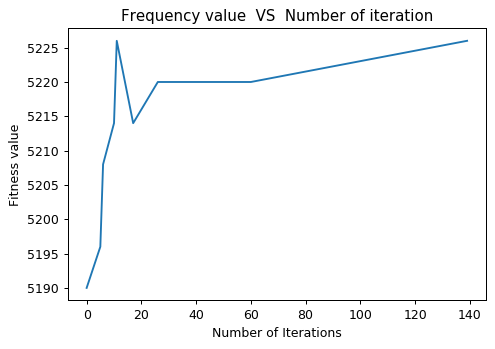

In [22]:
plt.figure(dpi = 90)
plt.title("Frequency value  VS  Number of iteration")
plt.xlabel('Number of Iterations')
plt.ylabel('Fitness value')
plt.plot(list(graph.keys()), list(graph.values()))
plt.show()